In [31]:
import numpy as np
import cv2
from scipy.interpolate import splprep, splev
from scipy.integrate import quad
from ultralytics import YOLO
from sklearn.linear_model import RANSACRegressor

# 初始化YOLO模型
yolo = YOLO("runs/train/exp-seg-EIOU/weights/best.pt", task="detect")

def extract_feature_points(mask, interval=20):
    # 使用形态学操作清理掩码
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # 找到所有轮廓
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return np.array([])  # 如果没有找到轮廓，返回空数组
    
    # 选择最大的轮廓
    largest_contour = max(contours, key=cv2.contourArea)
    
    # 从轮廓中均匀提取特征点
    points = []
    for i in range(0, len(largest_contour), interval):
        point = largest_contour[i][0]
        points.append((point[0], point[1]))

    return np.array(points)

def fit_curve_and_get_length(points):
    # 确保点是按x坐标排序的，防止曲线拟合时交叉
    points = points[points[:, 0].argsort()]

    # 使用RANSAC拟合更鲁棒的曲线
    model_ransac = RANSACRegressor()
    model_ransac.fit(points[:, 0].reshape(-1, 1), points[:, 1])

    # 使用样条插值拟合曲线
    tck, _ = splprep([points[:, 0], points[:, 1]], s=0, k=3)

    # 创建更密集的点集来绘制平滑曲线
    t = np.linspace(0, 1, 1000)
    smooth_points = np.array(splev(t, tck)).T

    # 计算曲线长度
    def curve_length_integrand(t):
        dx_dt, dy_dt = splev(t, tck, der=1)
        return np.sqrt(dx_dt**2 + dy_dt**2)

    length, _ = quad(curve_length_integrand, 0, 1)
    
    return smooth_points, length

def draw_curve(image, points, mask, color=(0, 255, 255), thickness=2):
    points = np.array(points).astype(int)
    for i in range(len(points) - 1):
        pt1 = tuple(points[i])
        pt2 = tuple(points[i + 1])
        
        # 只有当两个点都在掩码内时才绘制线段
        if mask[pt1[1], pt1[0]] > 0 and mask[pt2[1], pt2[0]] > 0:
            cv2.line(image, pt1, pt2, color, thickness)

# 主程序
source = cv2.imread('datasets/mogu_labels_2/images/train/1_20240529_135224.jpg')
source = cv2.resize(source, (640, 640))

result = yolo(source, save=True)

if result[0].masks is not None and len(result[0].masks) > 0:
    masks_data = result[0].masks.data
    
    for mask in masks_data:
        mask = (mask.cpu().numpy() * 255).astype(np.uint8)
        
        feature_points = extract_feature_points(mask)
            
        if len(feature_points) > 1:
            smooth_points, curve_length = fit_curve_and_get_length(feature_points)
            draw_curve(source, smooth_points, mask)
            
            print(f"Curve length: {curve_length:.2f} pixels")
            
            # 只在掩码区域内绘制特征点
            for point in feature_points:
                if mask[point[1], point[0]] > 0:  # 检查点是否在掩码内
                    cv2.circle(source, tuple(point), 2, (0, 255, 0), -1)
    
    # 保存结果图像
    cv2.imwrite('result_with_navigation_and_curves.jpg', source)
    print("Saved result image with navigation line and curves")
else:
    print("No masks found in the result")


0: 640x640 8 Stage1s, 4.0ms
Speed: 3.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict130
Curve length: 451.57 pixels
Curve length: 587.88 pixels
Curve length: 788.82 pixels
Curve length: 441.73 pixels
Curve length: 460.47 pixels
Curve length: 644.01 pixels
Curve length: 218.66 pixels
Curve length: 565.53 pixels
Saved result image with navigation line and curves


C:\Users\Administrator\AppData\Local\Temp\ipykernel_20684\2477837516.py:53: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  length, _ = quad(curve_length_integrand, 0, 1)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_20684\2477837516.py:53: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up 

In [32]:
result[0]

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'Stage1', 1: 'Stage2', 2: 'Stage3', 3: 'Stage4'}
obb: None
orig_img: array([[[ 92, 132, 174],
        [ 81, 124, 163],
        [102, 144, 183],
        ...,
        [ 83, 121, 155],
        [ 77, 116, 148],
        [ 73, 109, 142]],

       [[ 99, 139, 181],
        [ 90, 133, 172],
        [ 95, 138, 176],
        ...,
        [ 78, 118, 150],
        [ 78, 117, 149],
        [ 75, 110, 143]],

       [[106, 149, 190],
        [ 83, 125, 167],
        [ 95, 140, 177],
        ...,
        [ 84, 122, 154],
        [ 79, 117, 149],
        [ 77, 112, 145]],

       ...,

       [[122, 167, 205],
        [119, 164, 202],
        [124, 170, 209],
        ...,
        [105, 147, 184],
        [104, 146, 183],
        [100, 144, 181]],

       [[126, 173, 211],
        [122, 167, 205],
        [119, 165, 205],
  

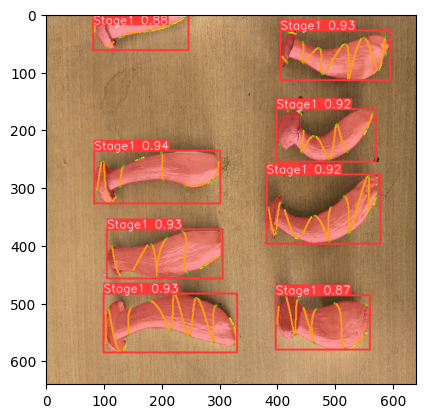

In [33]:
# 检测结果可视化
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(result[0].plot()[:,:,::-1])

In [34]:
result[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
conf: tensor([0.9381, 0.9345, 0.9273, 0.9259, 0.9232, 0.9223, 0.8782, 0.8741], device='cuda:0')
data: tensor([[8.3138e+01, 2.3672e+02, 3.0195e+02, 3.2753e+02, 9.3807e-01, 0.0000e+00],
        [4.0531e+02, 2.8037e+01, 5.9548e+02, 1.1416e+02, 9.3446e-01, 0.0000e+00],
        [9.9827e+01, 4.8393e+02, 3.3004e+02, 5.8571e+02, 9.2731e-01, 0.0000e+00],
        [1.0504e+02, 3.7289e+02, 3.0576e+02, 4.5796e+02, 9.2585e-01, 0.0000e+00],
        [3.9833e+02, 1.6407e+02, 5.7007e+02, 2.5544e+02, 9.2315e-01, 0.0000e+00],
        [3.8131e+02, 2.7707e+02, 5.7864e+02, 3.9770e+02, 9.2231e-01, 0.0000e+00],
        [8.1674e+01, 1.3214e-01, 2.4687e+02, 6.2122e+01, 8.7819e-01, 0.0000e+00],
        [3.9778e+02, 4.8611e+02, 5.6059e+02, 5.8058e+02, 8.7407e-01, 0.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([8, 6])
xywh: tensor([[192.5431, 282.

In [35]:
result[0].masks.xy

[array([[        199,         240],
        [        198,         241],
        [        195,         241],
        [        194,         242],
        [        193,         242],
        [        192,         243],
        [        188,         243],
        [        187,         244],
        [        181,         244],
        [        180,         245],
        [        178,         245],
        [        177,         246],
        [        176,         246],
        [        175,         247],
        [        173,         247],
        [        172,         248],
        [        168,         248],
        [        167,         249],
        [        165,         249],
        [        163,         251],
        [        162,         251],
        [        161,         252],
        [        157,         252],
        [        156,         253],
        [        155,         253],
        [        153,         255],
        [        151,         255],
        [        150,       